## Task 1 : Quantum Simulator from Scratch
In this notebook, we will implement a Quantum Simulator from scratch, meaning we will not be using any pre-built libraries or packages. The simulator will take a stare and a gate and output a probability distribution as a string. The idea is quite simple. 

### Quantum State
We represent the state of any given system quantum mechanically using Quantum states. Quantum states represent a system in terms of its measurable/observable outcomes, where each outcome has some probability of being observed. We represent a general N-dimensional Quantum state using a vector of complex values as follows :

$[a1, a2, . . . , aN]$

Where a1, a2, . . . , aN are the **probability amplitudes** for each observable outcome. In Quantum Mechanics, we use probability amplitudes, which are complex values, and this complex nature is what allows us to have quantum properties such as interference (as compared to classical probability theory where we do not observe any interference such as cancelling behaviors given we never have any negative probabilities). 

### Quantum Gate
We represent any operation to be applied to our Quantum state using Quantum gates. Quantum gates are applied to Quantum states as operations and in doing so, they change the Quantum states' values, thus the definition of a system is changed. When we apply multiple, we get an **evolution** for a system. Quantum gates are represented by unitary matrices of complex values i.e., the X gate which performs a bit flip :

$ \begin{bmatrix}
0 & 1 \\
1 & 0 
\end{bmatrix}  $

### Quantum Simulator
In Quantum Mechanics, we have states and operations, and we perform a computation by applying an operation to a state. A Quantum simulator is essentially a linear simulator, which takes a vector and a matrix, and multiplies them together to derive a new vector. 

We will begin by importing two packages for convenience, random and math.

In [2]:
# General imports
import random
import math 
import numpy as np 
import itertools

# Visualization imports
import matplotlib.pyplot as plt

In [40]:
random.seed(0)

Since this is a Quantum Simulator with the purpose of simulating a QPU, we will use qubits, which are two-level quantum states. Below we will define three qubits, and initialize them in an equal superposition state. We have 1 qubit, thus there will be two possible states.

In [3]:
# Define the number of qubits in our quantum register
n_qubits = 1

# Define an initial state vector with equal probability for all states
init_state = [1 / math.sqrt(2**n_qubits)] * 2**n_qubits

In [4]:
init_state

[0.7071067811865475, 0.7071067811865475]

Next, we will be implementing the main block of our simulator which takes a gate, a state, and a noise level and performs the operation.

In [5]:
# Define quantum gates, including a noise gate that introduces a small amount of random noise in each gate
def apply_gate(gate, state, noise_level=0.01):
    """Here is the main block of our simulator which takes a gate, a state, and a noise level and performs the operation. 

    Args:
        gate (np.ndarray): 
            The gate matrix.

        state (np.array):
            The state vector.
            
        noise_level (float):
            The noise level.
        
    Returns:
        (numpy.array): The state vector after the operation.
    """
    # Apply the gate
    new_state = [0] * len(state) # First we will initialize our updated state
    for i in range(len(state)):
        new_state[i] = sum([gate[i][j] * state[j] for j in range(len(state))]) # We will update the entries of the updated state based on the gate and initial state multiplication
    # Add noise
    for i in range(len(new_state)):
        noise = random.gauss(0, noise_level) # We will randomly choose some noise based on the noise level
        new_state[i] += noise # And apply it to our state 
    # Normalize the state
    norm = math.sqrt(sum([abs(new_state[i])**2 for i in range(len(new_state))])) # To ensure our state is a valid quantum state, we must normalize to 2-norm
    new_state = [new_state[i] / norm for i in range(len(new_state))]
    # Return new state
    return new_state 

Let's test it out! We will define the Hadamard, Pauli X and Pauli Z gates for testing.

In [6]:
# Define quantum gates
h = [[1/math.sqrt(2), 1/math.sqrt(2)],
     [1/math.sqrt(2), -1/math.sqrt(2)]]

x = [[0, 1],
     [1, 0]]

z = [[1, 0],
     [0, -1]]

In [7]:
# Apply the quantum gates to the initial state vector
state = init_state
state_h = apply_gate(h, state) # The state after applying Hadamard gate
state_x = apply_gate(x, state) # The state after applying the Pauli X gate
state_z = apply_gate(z, state) # The state after applying the Pauli Z gate

In [8]:
def calculate_dist(state, shots):
    """Here we will find the measured states and return them as a bit-string. 

    Args:
        state (np.array):
            The state vector.
            
        shots (int):
            The number of shots.
        
    Returns:
        (numpy.array): The measured state bit-string after the operation.
    """
    # Calculate the probability of measuring each state in the final state vector
    probs = [abs(state[i])**2 for i in range(len(state))]
    print(probs)
    # Generate a bit-string of the measured states, weighted by their corresponding probabilities
    bit_string = ''
    count_one = 0
    count_zero = 0
    for i in range(shots):
        rand = random.uniform(0, 1)
        if rand <= probs[0]:
            bit_string += '0'
            count_zero += 1
        else:
            bit_string += '1'
            count_one += 1
    return bit_string, [count_zero, count_one]

In [9]:
calculate_dist(state_x, 20)

[0.5099438388804204, 0.49005616111957956]


('01101100111101101100', [8, 12])

## Improvement

The current simulator is rather elementary, and cannot simulate circuits in the traditional sense, where we would apply gates in a sequence to certain qubits. The approach above is simply to familiarize the reader with how to think about the process. Now, we will take it a step further to write a more elegant code which can be compared to Qiskit's simulator. 

The main components are the same, however we will be defining them more rigorously.

Below we will define the **Qubit** class.

In [10]:
class Qubit:
    def __init__(self, c1, c2):
        """ Here we construct a qubit by specifying two complex coefficients c1, c2 such that c1.c1† + c2.c2† = 1 (Born rule).
        
        Args :
            c1 (complex): 
                complex float for state |0>
            c2 (complex): 
                complex float for state |1>
        """
        try: # We will make sure the state is a valid quantum state (Born rule)
            assert isclose((np.sqrt(c1*c1.conjugate() + c2*c2.conjugate())), 1.0, abs_tol=1e-4)
        except AssertionError as error:
            print(c1, c2)
            print(error)
        else:
            self.state = np.array([c1, c2]) # Define the state

    def dirac_representation(self):
        """ Here we plot the qubit state in dirac notation (|psi> = c0|0> + c1|1>).
        """
        return "{0}|0> + {1}|1>".format(self.state[0], self.state[1])

    def measure(self, shots=1):
        """ Here we measure the state based on the number of shots determining the number of measurements.
        
        Args :
            shots (int) : 
                Number of measurements.
        
        Returns: 
            (np.array) : Results of each measurement.
        """
        prob_one = self.state[1]*self.state[1].conjugate() # Probability of observing 1 (we can similarly do so for observing 0)
        result = np.random.binomial(1, prob_one, size=shots) # Using np.random.binomial to find the measured outcome based on the probability distribution
        return result # Returning the list of measured outcomes

In [11]:
def generate_states(control_bit, target_bit, n):
    """ Here we generate all possible binary integers of bit length n based on the known control_bit, target_bit positions held constant, and return the list of all binary variations as bit-strings.
    
    Args:
        control_bit (int):
            Control qubit index.
            
        target_bit (int):
            Target qubit index.
        
        n (int):
            Length of state.
        
    Returns: 
        (np.array) : list of bit-strings.
    """
    # Generate all possible binary combinations for n bits
    binary_combinations = [list(i) for i in itertools.product([0, 1], repeat=n)]
    return_list = []  # Create an empty list to be populated

    # For all elements, replace the first bit element to first bit value, similarly for the second bit
    for i in range(len(binary_combinations)):
        binary_combinations[i][control_bit] = 1
        binary_combinations[i][target_bit] = 0

        # Convert each list to a bit-string
        strings = [str(i) for i in binary_combinations[i]]
        bin_string = "".join(strings)

        # Only add to the return list if it's unique
        if bin_string not in return_list:
            return_list.append(bin_string)

    return return_list # Return the list of all possible measurable outcomes

In [12]:
def get_binary(x, n):
    """ Here we determine the binary representation of an int x (base 10) given that x <= 2^n where n is an int representing the total bit length.
    
    Args :
        x (int): 
            base 10 int of interest.
        n (int): 
            bit length.
    
    Returns : 
        (str) : x written in base 2.
    """
    binary_result = ''
    target = x

    for i in np.arange(n-1, -1, -1):
        if 2**i > target:
            binary_result += '0'
        else:
            binary_result += '1'
            target -= 2**i

    return binary_result

Below we will define the Circuit class, which encompasses the gates and the simulator with addition of noise.

In [37]:
class Circuit:
    """
    Part 1 : Gate Construction
    """
    
    hadamard_matrix = 1 / np.sqrt(2) * np.array([[1,  1],
                                                 [1, -1]])

    pauliX_matrix = np.array([[0, 1],
                              [1, 0]])

    pauliY_matrix = np.array([[0, -1j],
                              [1j, 0]])

    pauliZ_matrix = np.array([[1, 0],
                              [0, -1]])

    gate_to_matrix = {'H': hadamard_matrix,
                      'X': pauliX_matrix,
                      'Y': pauliY_matrix,
                      'Z': pauliZ_matrix}

    def __init__(self, num_qubits):
        """ Here we construct a circuit by specifying the number of qubits.
        
        Args :
            num_qubits (int): 
                The number of qubits in the circuit.
        """
        assert(num_qubits > 0)  # Making certain we don't have a circuit without any qubits

        circuit_state = np.zeros(2**num_qubits, dtype=float)  # Initializing the circuit state in |000...0>
        circuit_state[0] = 1.0                               

        self.circuit_state = circuit_state  # Setting the circuit state
        self.num_qubits = num_qubits # Setting the number of qubits
        self.gate_array = []  # Initializing a list for the gates to be applied

    def __repr__(self):
        """ Here we create a string display of the circuit for visualization.
        """
        display = ''
        circuit_rows = []

        for i in range(self.num_qubits):
            circuit_rows.append(['q{}: |0>--'.format(i)]) # Initializing each qubit in the 0 state

        for gate_operation in self.gate_array:
            # Controlled qubit gates
            if len(gate_operation) == 3: # We have a target index, a control index, and the gate to be applied to the target qubit
                control_index = gate_operation[1][0]
                target_index = gate_operation[1][1]

                circuit_rows[control_index].append('▀-') # Plotting the control unitary
                circuit_rows[target_index].append('{}-'.format(gate_operation[2])) # Plotting the target gate (TX, TY, TZ, TH)
            
            # Single qubit gates
            else:
                for index in gate_operation[1]:
                    circuit_rows[index].append(gate_operation[0] + '--') # Plotting single qubit gates

            max_len = max([len(row) for row in circuit_rows])
            for row in circuit_rows:
                while len(row) < max_len:
                    row.append('---')

        for row in circuit_rows:
            display += "".join(row) + '--Measurement\n'

        return display # Returning the string of the circuit

    def apply_noise(self, noise_level=0.0):
        """ Here we add the noise to our circuit for each operation.
        
        Args : 
            noise_level (float):
                The noise level.
        """
        new_state = self.circuit_state
        
        # Adding noise
        for i in range(len(new_state)):
            noise = random.gauss(0, noise_level) # We will randomly choose some noise based on the noise level
            new_state[i] += noise # And apply it to our state 
        
        # Normalizing the state
        norm = math.sqrt(sum([abs(new_state[i])**2 for i in range(len(new_state))])) # To ensure our state is a valid quantum state, we must normalize to 2-norm
        new_state = [new_state[i] / norm for i in range(len(new_state))]
        
        # Updating circuit state
        self.circuit_state = new_state
        
    def add_singleQubit_gate(self, qubit, gate):
        """ Here we add an abstract single qubit gate to the circuit based on the qubit index and gate chosen.
        
        Args :
            qubit (int OR np.array): 
                List of qubit index/indices to apply the gate to.
            gate (str): 
                The string for the gate to apply.
        """
        if not type(qubit) is list: # Making sure the datatype for the qubit is a list
            qubit = [qubit]
            
        gate_operation = (gate, qubit)         # Storing the data required for the circuit operation
        self.gate_array.append(gate_operation)    # Storing the gate_array for the circuit

    def add_controlledQubit_gate(self, control_index, target_index, gate):
        """ Here we add an abstract controlled qubit gate to the circuit based on the target and control qubit index and gate chosen.
        
        Args :
            control_index (int): 
                The control qubit index.
            target_index (int): 
                The target qubit index.
            gate (str): 
                The string for the gate to apply.
        """
        gate_operation = ('CQ', [control_index, target_index], gate)  # Storing the data required for the circuit operation (Control qubit, Target qubit, gate to be applied)
        self.gate_array.append(gate_operation)                        # Storing the gate_array for the circuit

    def apply_controlled_gate(self, control_index, target_index, gate_matrix, noise_level):
        """ Here we apply the control unitary so that the gate is applied based on the control qubit.
        
        Args : 
            control_index (int): 
                The control qubit index.
            target_index (int): 
                The target qubit index.
            gate_matrix (np.ndarray): 
                The unitary matrix corresponding to the gate.
            noise_level (float):
                The noise_level.
        """
        # Adjusting indices based on common notation
        control_index = self.num_qubits - (control_index + 1)
        target_index = self.num_qubits - (target_index + 1) 
        unique_qubit_combinations = generate_states(control_index, target_index, self.num_qubits)
        
        # Iterating over all unique combinations
        for combination in unique_qubit_combinations:  
            qubit_zero_combination = combination
            qubit_one_combination = combination[:target_index] + '1' + combination[target_index + 1:]
            index_zero = int(qubit_zero_combination, 2)
            index_one = int(qubit_one_combination, 2)

            state_vector = np.array([self.circuit_state[index_zero], self.circuit_state[index_one]]) # Defining the state
            state_vector = gate_matrix @ state_vector # Applying the gate to the state vector
            
            # Updating components of the circuit state vector
            self.circuit_state[index_zero] = state_vector[0] 
            self.circuit_state[index_one] = state_vector[1]
            self.apply_noise(noise_level)

    def apply_gate(self, gate_matrix, noise_level):
        """ Here we apply the gate unitary matrix to the circuit state to update it. Since single qubit gates are tensor decomposable, we can combine them outside of the tensor product and apply them directly to the state vector.
        
        Args : 
            gate_matrix (np.ndarray): 
                The gate unitary matrix.
            noise_level (float):
                The noise_level.
        """
        self.circuit_state = gate_matrix @ self.circuit_state # Applying the gate to the circuit state
        self.apply_noise(noise_level)

    # Quick access for applying gates similar to Qiskit
    def h(self, qubit):
        self.add_singleQubit_gate(qubit, 'H')

    def ch(self, control_qubit, target_qubit):
        self.add_controlledQubit_gate(control_qubit, target_qubit, 'H')

    def x(self, qubit):
        self.add_singleQubit_gate(qubit, 'X')

    def cx(self, control_qubit, target_qubit):
        self.add_controlledQubit_gate(control_qubit, target_qubit, 'X')

    def y(self, qubit):
        self.add_singleQubit_gate(qubit, 'Y')

    def cy(self, control_qubit, target_qubit):
        self.add_controlledQubit_gate(control_qubit, target_qubit, 'Y')

    def z(self, qubit):
        self.add_singleQubit_gate(qubit, 'Z')

    def cz(self, control_qubit, target_qubit):
        self.add_controlledQubit_gate(control_qubit, target_qubit, 'Z')
    
    """
    Part 2 : Circuit Simulation
    """
        
    def run(self, noise_level,status=True):
        """ Here we will update the circuit_state vector to illustrate the results of the circuit after being run.
        
        Args :
            noise_level (float):
                    The noise_level.
            status (bool): 
                Logging messgaes as we process the circuit.
        """
        total_layers = len(self.gate_array)
        
        # Iterating over all the layers of the circuit
        for layer, gate_operation in enumerate(self.gate_array):
            # If logging status is set to True, we print out the completed layers' checkpoint as we proceed (we recommend turning this on for deep PQCs for keeping track of the progress)
            if status is True:
                print('Processing layer {}/{} ...'.format(layer + 1, total_layers))

            gate_str = gate_operation[0]
            
            # Running the Controlled qubit gates
            if gate_str == 'CQ':                      
                control_index = gate_operation[1][0]       
                target_index = gate_operation[1][1]
                gate_matrix = self.gate_to_matrix[gate_operation[2]] 
                
                # Applying the gate
                self.apply_controlled_gate(control_index, target_index, gate_matrix, noise_level)  
            
            # Running the Single qubit gates
            else:
                gate = np.eye(2)  
                if self.num_qubits - 1 in gate_operation[1]:  
                    gate = self.gate_to_matrix[gate_str]    
                
                # Running for each qubit at each layer
                for index in np.arange(self.num_qubits - 2, -1, -1):   
                    unitary_matrix = self.gate_to_matrix[gate_str]

                    qubit_gate = np.eye(2)
                    if index in gate_operation[1]:        
                        qubit_gate = unitary_matrix
                    gate = np.kron(gate, qubit_gate)   
                
                # Applying the gate
                self.apply_gate(gate, noise_level)                 
        
        # If logging status is set to True, we print out Done! when the running has completed
        if status is True:
            print('Done!')
        # Emptying the gate list (we do so that when we add new gates to the circuit, we don't re-run the old gates on the updated state)
        self.gate_array = []

    def simulate(self, shots=100)->dict:
        """ Here we simulate repeated measurements on the prepared state.
        
        Args :
            shots (int):
                The number of measurements of the circuit.
        
        Return : 
            (dict): The dictionary where the keys are a bit-string representing the measured state, and the value is the number of observations for that state.
        """
        probabilities = [i * np.conj(i) for i in self.circuit_state]  
        # Protocol for when we have a Real Amplitude PQC
        try:
            probabilities = [float(i) for i in probabilities]        
        except np.ComplexWarning:
            probabilities = [float(i) for i in probabilities]       

        results = np.random.multinomial(shots, probabilities, size=1) # Drawing the result based on the distribution and number of shots
        counts = {}

        for index, value in enumerate(results[0]):
            key = get_binary(index, self.num_qubits) # Determining the bit-string representation of the measured state
            counts[key] = value

        return counts # Returning the dictionary

## Testing
Below we will test out the new approach with a few noise levels. We will be testing the Bell state to test both single qubit as well as multi-qubit operations in one circuit.

This is the circuit:
q0: |0>----Measurement
q1: |0>----Measurement

q0: |0>--H--▀---Measurement
q1: |0>-----X---Measurement

The state vector from qsim is : [0.7071067811865476, 0.0, 0.0, 0.7071067811865476]
{'00': 520, '01': 0, '10': 0, '11': 504}


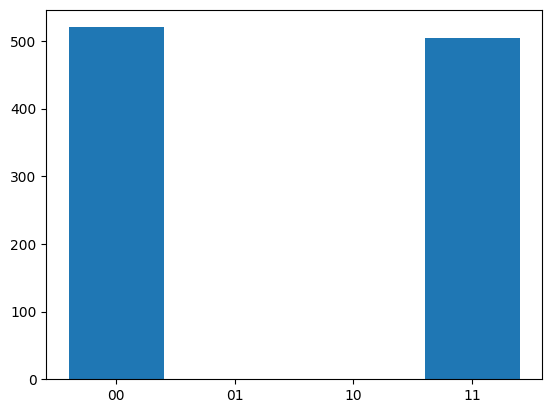

This is the circuit:
q0: |0>----Measurement
q1: |0>----Measurement

q0: |0>--H--▀---Measurement
q1: |0>-----X---Measurement

The state vector from qsim is : [0.6450811131971808, 0.12545985491240358, 0.0903790200238968, 0.7483059634542308]
{'00': 433, '01': 18, '10': 6, '11': 567}


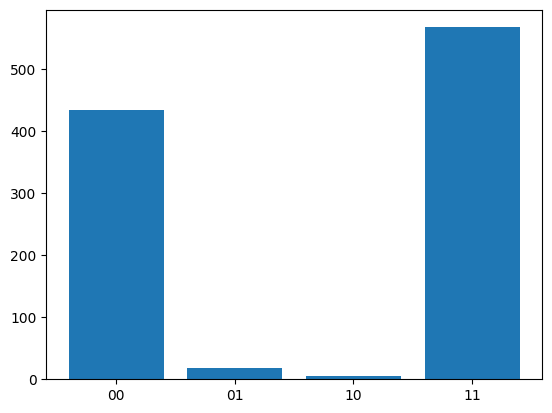

This is the circuit:
q0: |0>----Measurement
q1: |0>----Measurement

q0: |0>--H--▀---Measurement
q1: |0>-----X---Measurement

The state vector from qsim is : [0.5850336976426581, -0.049745120692148974, -0.36467007311658944, 0.7226871614765437]
{'00': 368, '01': 4, '10': 140, '11': 512}


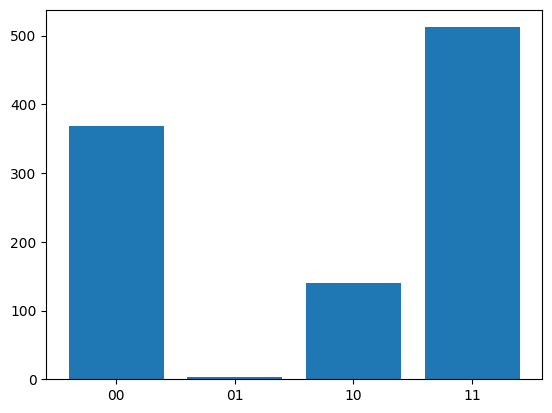

This is the circuit:
q0: |0>----Measurement
q1: |0>----Measurement

q0: |0>--H--▀---Measurement
q1: |0>-----X---Measurement

The state vector from qsim is : [0.618646034867466, -0.6115268024080109, 0.37585368208658987, 0.3194464949586208]
{'00': 389, '01': 406, '10': 137, '11': 92}


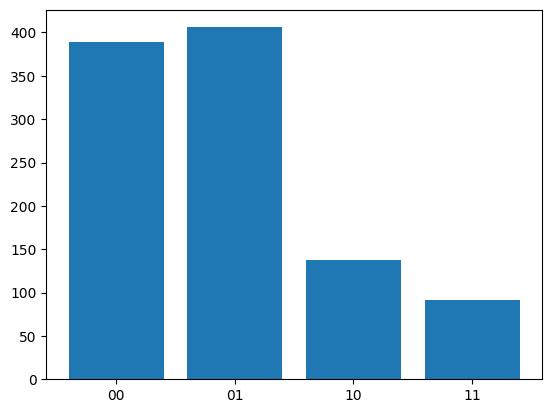

In [42]:
noise_list = [0.0, 0.1, 0.2, 0.5]
for i in range(len(noise_list)):
    # initializing a quantum circuit using quantum simulator: 
    circ = Circuit(2)
    print('This is the circuit:')  
    print(circ)
    
    circ.h(0) # Applying hadamard gate to first qubit 
    circ.cx(0,1)        # A a CX gate to first qubit and second qubit 
    print(circ)
    
    # display the state vectors for each circuit 
    circ.run(status=False, noise_level=noise_list[i])
    print('The state vector from qsim is : {}'.format(circ.circuit_state))
    
    # plot 1024 simulated measurements of circuits:
    counts = circ.simulate(shots=1024)
    print(counts)
    
    plt.bar(range(len(counts)), counts.values()) # Bar chart of measured state occurences
    plt.xticks(range(len(counts)), list(counts.keys()))
    plt.show()